# A Brief Overview on Rejection Sampling

Suppose we have a pdf, $f(x)$, defined below that we want to generate samples from. 

$$ f(x) = \frac{e^{-x^4}sin(10x)^2}{\int_{-\infty}^{\infty} e^{-t^4}sin(10t)^2 dt} $$

To directly sample this with the inverse transform method, is pretty hard to do for several reasons:
*  Calculating the constant, $\int_{-\infty}^{\infty} e^{-t^4}sin(10t)^2 dt$ takes a lot of work
*  Getting the CDF, $\int_{-\infty}^x f(x) dx$ also takes a lot of work
*  Once the CDF is found, inverting this will be a lot of work. 

If we really wanted to do this, we could. However, this example is just in 1d. When this problem is scaled to the n'th dimetion, 
it gets very computationally expensive to do this amount of work. 

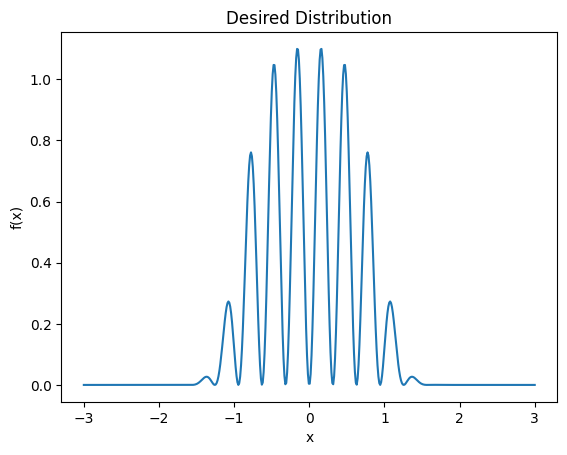

In [1]:
import numpy as np
import scipy
from matplotlib import pyplot as plt

# Note here that we did not include the integration constant divisor.
# Shortly, we will apply a little trick to `cancel this out` in order to do less work.
def f_target(x):
    return np.exp(-x ** 4) * np.sin(10 * x) ** 2

# plot the function. 
x = np.linspace(-3, 3, 500)
integration_constant = scipy.integrate.quad(f_target, -np.inf, np.inf)[0]
f_x = f_target(x) / integration_constant
plt.title('Desired Distribution')
plt.ylabel('f(x)')
plt.xlabel('x')
plt.plot(x, f_x)
plt.show()

## The Rejection Sampling Algorithm

In order to avoid the challenges presented with the inverse transform method, we can use rejection sampling to generate samples from a much easier distribution to sample from and then reject the ones that are not within the desired distribution.  

The algorithm to do this is:
* Propose a distribution, $g(x)$, and a constant, $C$, such that $f(x) \le C g(x) \quad \forall x \in \mathbb{R}$
* Generate a set of indapendent and identically distributed (i.i.d.) samples that follow the distribution $g(x)$. 
* Generate **another** set of i.i.d. samples from Uniform [0,1]
* Accept the samples that meet the condition:
$$ U \le \frac{f(X)}{C g(X)}$$

 ### Selecting g(x) and C
 Since $f(x)$ has an exponential decay, we will choose $g(x)$ to be the exponential distribution:

$$ g(x) = e^{-|x|} $$
 
 Now, we must find the constant $C$ such that:
$$ \frac{e^{-x^4}sin(10x)^2}{\int_{-\infty}^{\infty} e^{-t^4}sin(10t)^2 dt} \le C e^{-|x|}$$

Recall that the normalization integral constant in the denominator of $f(x)$ was one of the things that was challenging to compute.
Since we have the freedom to choose whatever C we want to suffice this condition, let's choose a C that will cancel out this nasty integral. 
$$ \mathrm{let} \quad Z = \int_{-\infty}^{\infty} e^{-t^4}sin(10t)^2 dt $$
$$ \frac{e^{-x^4}sin(10x)^2}{Z} \le C e^{-|x|}$$
Now let's set $C = \frac{D}{Z}$. Thus, 
$$ \frac{e^{-x^4}sin(10x)^2}{Z} \le \frac{D}{Z} e^{-|x|}$$
$$ e^{-x^4}sin(10x)^2 \le D e^{-|x|}$$

This new constant, $D$, is much easier to solve for. From a simple inspection of $f(x)$, we can see that since sine takes values [0,1], 
it will only reduce the value of the exponential term. Thus, we can simplify the problem to: 
 $$ e^{-x^4} \le D e^{-|x|}$$

Now notice that $e^{-x^4} \le e^{-|x|} \quad \forall |x| \ge 1$. Thus, we just have to find D on the interval $-1 < x < 1$, and 
by symetry this can be further reduced to the interval $0 < x < 1$. 
 $$ e^{-x^4} \le D e^{-|x|}$$
 $$ e^{-x^4 + |x|} \le D$$

By maxamizing $-x^4 + |x|$, we can find $D = e^{-(\frac{1}{4})^\frac{4}{3} + (\frac{1}{4})^\frac{1}{3}} \approx 1.603$


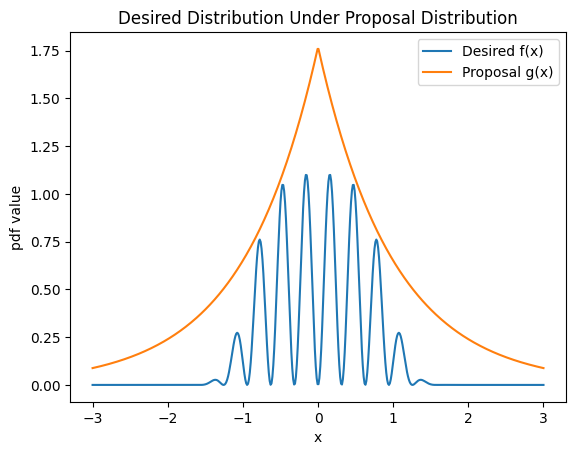

In [2]:
D = np.exp(-(1/4)**(4/3) + (1/4)**(1/3))
C = D / integration_constant

def g_selected(x):
    return scipy.stats.expon.pdf(np.abs(x))

g_x = C * g_selected(x)
plt.title('Desired Distribution Under Proposal Distribution')
plt.ylabel('pdf value')
plt.xlabel('x')
plt.plot(x, f_x, label='Desired f(x)')
plt.plot(x, g_x, label='Proposal g(x)')
plt.legend()
plt.show()

## Generating the Samples

Now that we have $g(x)$, and our modified constant $D$ all that is left to do is plug things in. To generate a sample, $X$, from $f(x)$, we generate a sample from 
$g(x)$ and a Uniform [0,1] sample. Then, as long as $ U \le \frac{f(X)}{C g(X)}$, we accept the sample because it also belongs to $f(x)$. 


Total Samples Generated: 353750
Samples Accepted: 100000 (28.27 %)


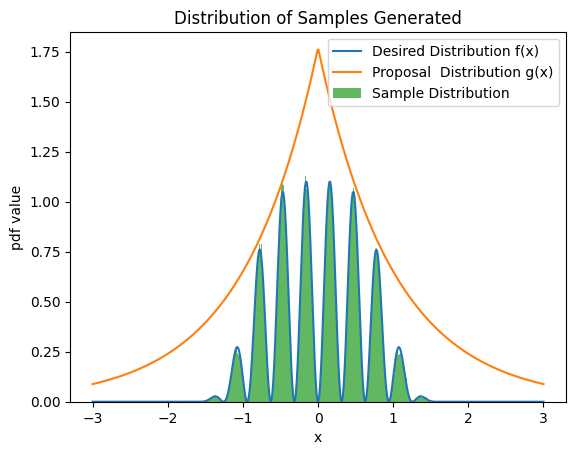

In [3]:
n = 100000
n_generated = 0
samples_f = []
while len(samples_f) < n:
    # generate U~uniform[0,1]
    uniform = np.random.uniform(0,1)
    # generate a X~Exp(|x|) (multiplying by -1 at random ror abs value in pdf)
    sample  = np.random.exponential() * np.random.choice([-1, 1])
    # count number of accepted samples to get the acceptance rate
    n_generated += 1
    # check if the sample should be rejected
    if uniform <= f_target(sample) / (D * g_selected(sample)):
        samples_f.append(sample)


print(f'Total Samples Generated: {n_generated}')
print(f'Samples Accepted: {n} ({round(n/n_generated * 100,2)} %)')

plt.title('Distribution of Samples Generated')
plt.ylabel('pdf value')
plt.xlabel('x')
plt.plot(x, f_x, label='Desired Distribution f(x)')
plt.plot(x, g_x, label='Proposal  Distribution g(x)')
plt.hist(samples_f, density=True, alpha=0.75, bins=500, label='Sample Distribution')
plt.legend()
plt.show()